In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.utils import np_utils
import tensorflow as tf


# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D,SeparableConv2D,DepthwiseConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers.normalization import BatchNormalization

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 14s 0us/step


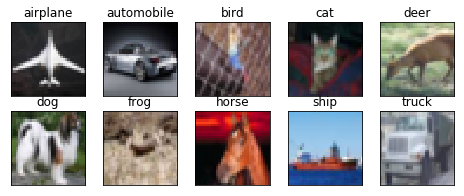

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_bs2(x):
 return tf.space_to_depth(x, block_size=2)

def space_to_depth_bs4(x):
 return tf.space_to_depth(x, block_size=4)


In [0]:
# Input layer
img = Input(shape=(32,32,3))
x1 = SeparableConv2D(64, kernel_size=5, padding='same', activation='relu')(img)  #32
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x2 = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x1)   #32
x2 = BatchNormalization()(x2)

x3 = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x2)   #32
x3 = BatchNormalization()(x3)
x3 = Dropout(0.2)(x3)

x4 = concatenate([x1, x3])

x4 = SeparableConv2D(64, kernel_size=5, padding='same', activation='relu')(x4)   #32
x4 = BatchNormalization()(x4)
x4 = Dropout(0.2)(x4)

m1 = concatenate([x1, x4])

m1 = MaxPooling2D(pool_size=(2, 2))(m1)                                        #16


y1 = SeparableConv2D(128, kernel_size=3, padding='same', activation='relu')(m1)  #16
y1 = BatchNormalization()(y1)
y1 = Dropout(0.2)(y1)

x4_2 = Lambda(space_to_depth_bs2)(x4)
y2 = concatenate([y1, x4_2])

y2 = Conv2D(128, kernel_size=5, padding='same', activation='relu')(y2)          #16
y2 = BatchNormalization()(y2)
y2 = Dropout(0.2)(y2)

x3_2 = Lambda(space_to_depth_bs2)(x3)
y3 = concatenate([x3_2, x4_2, y1, y2])

y3 = SeparableConv2D(128, kernel_size=3, padding='same', activation='relu')(y3) #16
y3 = BatchNormalization()(y3)
y3 = Dropout(0.2)(y3)

x1_2 = Lambda(space_to_depth_bs2)(x1)
y4 = concatenate([x1_2, x4_2, y1, y2, y3])

y4 = SeparableConv2D(128, kernel_size=5, padding='same', activation='relu')(y4) #16
y4 = BatchNormalization()(y4)
y4 = Dropout(0.2)(y4)

m2 = concatenate([y1, y3, x1_2, x4_2, y4])

m2 = MaxPooling2D(pool_size=(2, 2))(m2)                                        #8

y2_2 = Lambda(space_to_depth_bs2)(y2)
m2 = concatenate([y2_2, m2])

z1 = Conv2D(64, kernel_size=5, padding='same', activation='relu')(m2)          #8
z1 = BatchNormalization()(z1)
z1 = Dropout(0.2)(z1)

x1_4 = Lambda(space_to_depth_bs2)(x1_2)
x2_4 = Lambda(space_to_depth_bs4)(x2)
y3_2 = Lambda(space_to_depth_bs2)(y3)
z2 = concatenate([z1, y3_2, x2_4, x1_4])

z2 = SeparableConv2D(256, kernel_size=5, padding='same', activation='relu')(z2) #8
z2 = BatchNormalization()(z2)
z2 = Dropout(0.2)(z2)

x3_4 = Lambda(space_to_depth_bs4)(x3)
x2_4 = Lambda(space_to_depth_bs4)(x2)
y1_2 = Lambda(space_to_depth_bs2)(y1)
z3 = concatenate([z2, y1_2, z1, x3_4, x2_4])

z3 = Conv2D(256, kernel_size=3, padding='same', activation='relu')(z3)         #8
z3 = BatchNormalization()(z3)
z3 = Dropout(0.2)(z3)

x4_4 = Lambda(space_to_depth_bs4)(x4)
y1_2 = Lambda(space_to_depth_bs2)(y1)
z4 = concatenate([z3, x3_4, y3_2, z2, x4_4, y1_2, x1_4])

z4 = SeparableConv2D(256, kernel_size=5, padding='same', activation='relu')(z4) #8
z4 = BatchNormalization()(z4)
z4 = Dropout(0.2)(z4)

z5 = concatenate([z4, z2, x4_4, y3_2])


# z5 = Conv2D(10, kernel_size=8)(z5) #8

z5 = Flatten()(z5)
z5 = Dense(10)(z5)
output = Activation('softmax')(z5)


model = Model(inputs=[img], outputs=output)
# summarize layers
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_11 (SeparableC (None, 32, 32, 64)   331         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 32, 32, 64)   256         separable_conv2d_11[0][0]        
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 32, 32, 64)   0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
conv2d_9 (

In [0]:
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [0]:
from keras.optimizers import adam
adam = adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8,decay=0.005)
model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 120s 307ms/step - loss: 13.5944 - acc: 0.1540 - val_loss: 13.3281 - val_acc: 0.1724
Epoch 2/100
390/390 [==============================] - 115s 294ms/step - loss: 13.2044 - acc: 0.1804 - val_loss: 13.0126 - val_acc: 0.1923
Epoch 3/100
390/390 [==============================] - 114s 294ms/step - loss: 12.8561 - acc: 0.2017 - val_loss: 14.1884 - val_acc: 0.1194
Epoch 4/100
390/390 [==============================] - 115s 295ms/step - loss: 12.4885 - acc: 0.2242 - val_loss: 12.8867 - val_acc: 0.1997
Epoch 5/100
390/390 [==============================] - 115s 294ms/step - loss: 12.5083 - acc: 0.2231 - val_loss: 12.5055 - val_acc: 0.2235
Epoch 6/100
390/390 [==============================] - 115s 295ms/step - loss: 12.2785 - acc: 0.2373 - val_loss: 12.9287 - val_acc: 0.1974
Epoch 7/100
390/390 [==============================] - 115s 294ms/step - loss: 12.0671 - acc: 0.2505 - val_loss: 11.9160 - val_acc: 0.2599
Epoch 8/100
390/390 [======

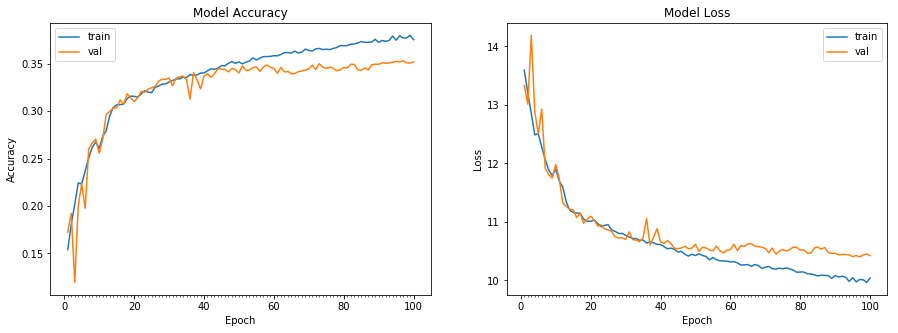

Accuracy on test data is: 35.19


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))